# Deep Learning for Coders, Part 1
### Assignment #1: Building a Baldwin Classifier

This is my first assignment for the [fast.ai](http://www.fast.ai/) [_Practical Deep Learning for Coders, Part 1_](http://course.fast.ai/) course, which I'm taking at the [Data Institute at the USF](https://www.usfca.edu/data-institute) in the fall of 2018.  

The [original notebook uses an existing data set to classify breeds of cats and dogs](https://github.com/fastai/course-v3/blob/master/nbs/dl1/lesson1-pets.ipynb).  Our assignment was to run that example then come up with our own data set.  

I decided to build something the world _truly_ needs right now: a Baldwin brother classifier.

Aside from the obvious benefits to our society of programmatic Baldwin classification (you're welcome!), I was really interested to try this twist on creating a model for a few reasons:
- Get experience creating my own dataset
- Refine the model on a comparatively small number of photographs (~180-220 per Baldwin)
- Try the optimization techniques with a dataset of faces at different resolutions and ages with a group of people who look somewhat similar

<img src="baldwins.jpg" />

### Getting the data
Getting the photos in a programmatic way was more of a challenge than I thought.  Here's what I tried:

1) [*Google Custom API*](https://developers.google.com/custom-search/) (includes an image search) - I was already using the Google Cloud to run the notebook so I thought this would be convienient, but ended up abandoning it when I spent 30 minutes trying to figure out a poorly documented 400 error.  I'll try it again in a future project.

2) [*Bing Image Search API*](https://azure.microsoft.com/en-us/services/cognitive-services/bing-image-search-api/) - This API is really well documented and the browser search got me slightly better results than Google (as in more solo photos of each person at high resolutions), but the API results were significantly less suitable and not as relevant.

3) [*Mix of JS and Python from a PyImageSearch post*](https://www.pyimagesearch.com/2017/12/04/how-to-create-a-deep-learning-dataset-using-google-images/) - This technique involves executing some JS code in the console to export a `.txt` file of the image URLS you want based on your search in the browser, then running some Python to download them to your computer.  This ended up being the fastest option this time, and the way it is done was a good learning experience.

Once I got the images downloaded, I took a pass of them to crop any that had other people in the shot and remove anything too low resolution or not relevant.  

Then I had to seperate them into `test`, `train` and `valid` folders.  I used 80% of each brothers' pictures for testing, 20% for training, then took 20% of the training set out for validation.  So my file structure looked like this:
```
/images

 |- test
   |- alec
   |- daniel
   |- stephen
   |- william
   
 |- train
   |- alec
   |- daniel
   |- stephen
   |- william
   
 |- valid
   |- alec
   |- daniel
   |- stephen
   |- william
```

### Creating the model
At this point, I'm running the code provided in the original lesson, but tweaking some of the parameters and importing my own data.  

In [9]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

I'm using the [fastai V1 library](http://www.fast.ai/2018/10/02/fastai-ai/) which sits on top of [Pytorch 1.0](https://hackernoon.com/pytorch-1-0-468332ba5163), and is an integral part of the course.

In [10]:
from fastai import *
from fastai.vision import *

## Looking at the data

First I create a path object to my `images` folder and list the subdirectories.

In [11]:
path = Path('./images')
path.ls()

['test', 'valid', 'train', 'models', '.ipynb_checkpoints']

Then I set up the tfms variable using the `get_transformations` function, which does some standard preprocessing to the images (scaling, cropping, etc).  Invoking the `ImageDataBunch` class and passing in the path to my files, the transformation instance and the size for cropping the images to (224 px square), and the `from_folder` method labels the images based on the name of the file they are in.  I now have a data set I can print from and check. 

In [12]:
tfms = get_transforms(do_flip=False)
data = ImageDataBunch.from_folder(path, ds_tfms=tfms, size=224)

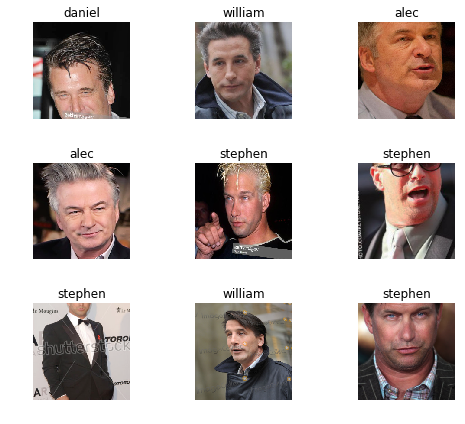

In [15]:
data.show_batch(rows=3, figsize=(7,6))

In [16]:
print(data.classes)
len(data.classes),data.c

['alec', 'daniel', 'stephen', 'william']


(4, 4)

Notice that the cropping and the scaling look a little off.  If this were a bigger project I would probably go back and work on this to see if it boosted accuracy, but it was good learning to see what crop jobs I did preserved the images and which made them worse. 😬

## Training: resnet34

Now, for the training, starting with the `resnet34` CNN model.  This is a pre-trained model, that has learned from thousands of images.  Applying this model to my new data set is called `transfer learning`.

In [17]:
learn = ConvLearner(data, models.resnet34, metrics=error_rate)

The original example had `4` as the argument for `learn.fit_one_cycle`.  This represents the number of epochs (or passes through the data to tune and test the model) but I found that I could generally improve the results a little with a couple more passes, and it didn't take that much longer to train.

In [18]:
learn.fit_one_cycle(8)

/opt/anaconda3/lib/python3.6/site-packages/PIL/Image.py:953: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')
/opt/anaconda3/lib/python3.6/site-packages/PIL/Image.py:953: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')
/opt/anaconda3/lib/python3.6/site-packages/PIL/Image.py:953: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')
/opt/anaconda3/lib/python3.6/site-packages/PIL/Image.py:953: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')
/opt/anaconda3/lib/python3.6/site-packages/PIL/Image.py:953: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')
/opt/anaconda3/lib/python3.6/site-packages/PIL/Image.py:953: UserWarning: Palette ima

Total time: 00:45
epoch  train loss  valid loss  error_rate
1      1.653014    1.239704    0.525000    (00:05)
2      1.429963    1.074108    0.425000    (00:05)
3      1.203241    1.059461    0.500000    (00:05)
4      1.040233    0.857043    0.375000    (00:05)
5      0.903576    0.880406    0.400000    (00:05)
6      0.784428    0.858534    0.325000    (00:05)
7      0.706694    0.842773    0.375000    (00:05)
8      0.645672    0.849027    0.375000    (00:05)



After all of the warnings about my images (again, something to delve into later!) We can see that the model took about a minute to train.  

I ran this a few times, clearing the output each time.  The results at the top are the last iteration.

`
*Iteration 1*
Total time: 01:00
epoch  train loss  valid loss  error_rate
1      1.707973    1.338027    0.575000    (00:06)
2      1.435365    1.144714    0.550000    (00:06)
3      1.229939    1.002109    0.350000    (00:05)
4      1.072951    0.862551    0.400000    (00:06)
5      0.927195    0.813938    0.325000    (00:06)
6      0.813120    0.670342    0.275000    (00:06)
7      0.724152    0.672214    0.250000    (00:06) <-- lowest error rate & last point tl>vl
8      0.640927    0.653829    0.250000    (00:05)
9      0.576649    0.643317    0.250000    (00:06)
10     0.526805    0.649857    0.250000    (00:05)`
`

*Iteration 2*
Total time: 00:59
epoch  train loss  valid loss  error_rate
1      1.634156    1.314249    0.575000    (00:06)
2      1.398415    1.022346    0.500000    (00:05)
3      1.198164    0.870431    0.425000    (00:05)
4      1.029826    0.842520    0.325000    (00:05)
5      0.908514    0.754280    0.275000    (00:06) <-- lowest error rate & last point tl>vl
6      0.794603    0.769435    0.300000    (00:05) 
7      0.704144    0.747361    0.325000    (00:06) 
8      0.614734    0.697811    0.325000    (00:06)
9      0.564776    0.692702    0.325000    (00:05)
10     0.519121    0.698875    0.350000    (00:06)


Total time: 01:02
epoch  train loss  valid loss  error_rate
1      0.191893    0.558673    0.150000    (00:05)
2      0.159558    0.580848    0.150000    (00:05)
3      0.155058    0.546549    0.150000    (00:06)
4      0.156406    0.493299    0.175000    (00:06)
5      0.158006    0.605078    0.175000    (00:06)
6      0.154560    0.615161    0.200000    (00:05)
7      0.142587    0.579476    0.175000    (00:05)
8      0.143955    0.559877    0.175000    (00:05)
9      0.141939    0.549844    0.175000    (00:07)
10     0.140428    0.557418    0.175000    (00:06)

Total time: 00:47
epoch  train loss  valid loss  error_rate
1      1.705843    1.148690    0.500000    (00:05)
2      1.415386    0.980210    0.350000    (00:05)
3      1.188656    0.998245    0.350000    (00:05)
4      1.015516    0.932578    0.375000    (00:05)
5      0.876939    0.772146    0.275000    (00:05)
6      0.762612    0.690294    0.250000    (00:06)
7      0.684501    0.695836    0.300000    (00:06)
8      0.626441    0.703167    0.275000    (00:05)


1) The error rate drops until the third epoch, drops slightly, then goes up a little in the fourth.  I think this might be the model reaching a local minimum.

2) The error rate starts dropping again on the fifth pass, but does not manage to drop below 25%, even as the training and validation loss drop or stay fairly flat.

3) The difference between trining



In [ ]:
learn.save('stage-1')

## Results

Let's see what results we have got. 

We will first see which were the categories that the model most confused with one another. We will try to see if what the model predicted was reasonable or not. In this case the mistakes look reasonable (none of the mistakes seems obviously naive). This is an indicator that our classifier is working correctly. 

Furthermore, when we plot the confusion matrix, we can see that the distribution is heavily skewed: the model makes the same mistakes over and over again but it rarely confuses other categories. This suggests that it just finds it difficult to distinguish some specific categories between each other; this is normal behaviour.

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.plot_top_losses(9, figsize=(15,11))

In [ ]:
doc(interp.plot_top_losses)

In [ ]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [ ]:
interp.most_confused(min_val=2)

## Unfreezing, fine-tuning, and learning rates

Since our model is working as we expect it to, we will *unfreeze* our model and train some more.

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(5)

In [ ]:
learn.load('stage-1')

In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot()

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-4,1e-3))

## Training: resnet50

Now we will train in the same way as before but with one caveat: instead of using resnet34 as our backbone we will use resnet50 (resnet34 is a 34 layer residual network while resnet50 has 50 layers. Later in the course you can learn the details in the [resnet paper](https://arxiv.org/pdf/1512.03385.pdf)).

Basically, resnet50 usually performs better because it is a deeper network with more parameters. Let's see if we can achieve a higher performance here.

In [ ]:
data = ImageDataBunch.from_folder(path, ds_tfms=get_transforms(), size=299, bs=30)
data.normalize(imagenet_stats)

In [ ]:
learn = ConvLearner(data, models.resnet50, metrics=error_rate)

In [ ]:
learn.fit_one_cycle(10)

In [ ]:
learn.save('stage-1-50')

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(1, max_lr=slice(1e-5,1e-4))

In this case it doesn't, so let's go back to our previous model.

In [ ]:
learn.load('stage-1-50')

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.most_confused(min_val=1)